In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import re
import copy
#import adtk
#from adtk.data import validate_series
#from adtk.visualization import plot
#from adtk.detector import ThresholdAD, QuantileAD, InterQuartileRangeAD, PersistAD, LevelShiftAD, VolatilityShiftAD
from IPython.display import display
from ydata_profiling import ProfileReport
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose


In [29]:
data = "../data/uebung/df_activity_30m.txt"
data2 = "../data/uebung/t001_1h.txt"

df_activity = pd.read_csv(
    data,
    delimiter=",",
    header=0,
    parse_dates=True,
)

df_t001 = pd.read_csv(
    data2,
    delimiter=",",
    header=0,
    parse_dates=True,
)



# display(df_aruba)
# print(df_aruba.info())
# df_aruba.dtypes

      DateTime_ISO8601  Value_num
0  2010-11-04 01:00:00       20.0
1  2010-11-04 02:00:00       19.5
2  2010-11-04 03:00:00       19.0
3  2010-11-04 04:00:00       19.0
4  2010-11-04 05:00:00       18.5


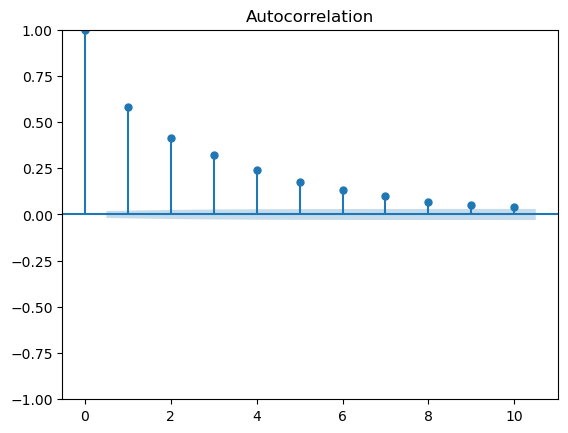

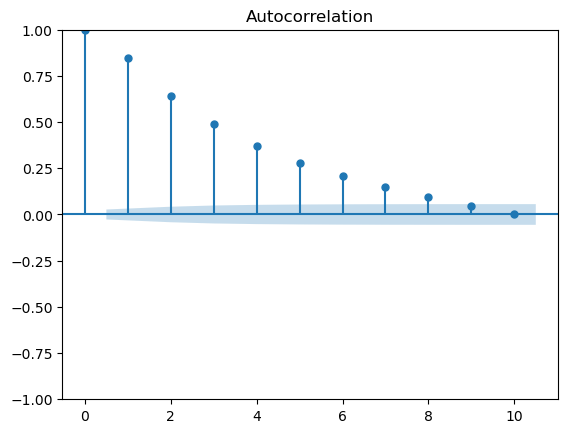

In [30]:
plot_acf(df_activity["Activity"], lags=10)
plot_acf(df_t001["Value_num"], lags=10)
print(df_t001.head())

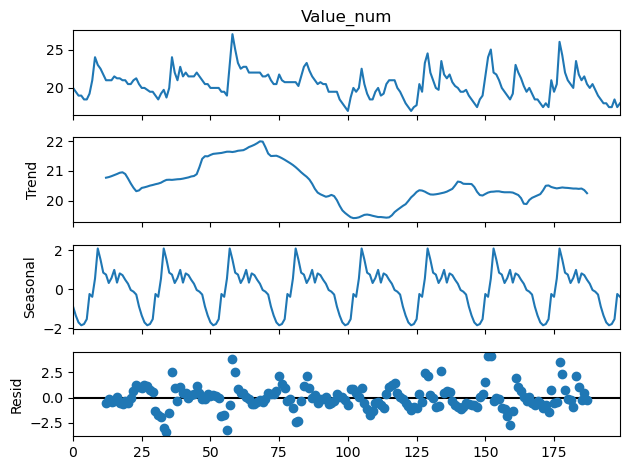

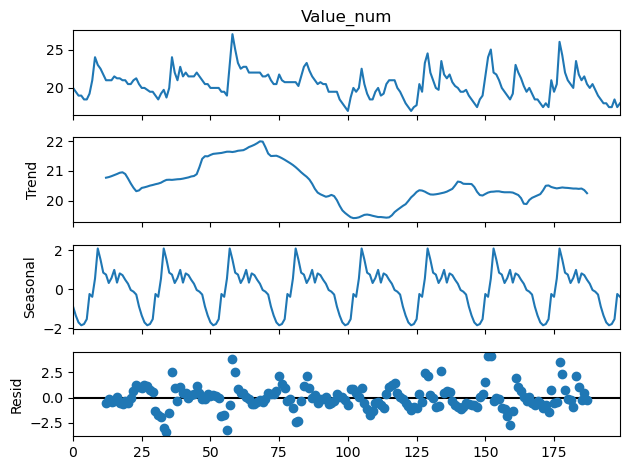

In [31]:
decomposed = seasonal_decompose(df_t001["Value_num"][:200], model='additive', filt=None, period=24, two_sided=True, extrapolate_trend=0)
decomposed.plot()

Trainingsdaten df_activity: 8447, Testdaten: 2112
Trainingsdaten df_t001: 4223, Testdaten: 1056
RMSE für Naive Vorhersage (df_activity): 128.71153441284542


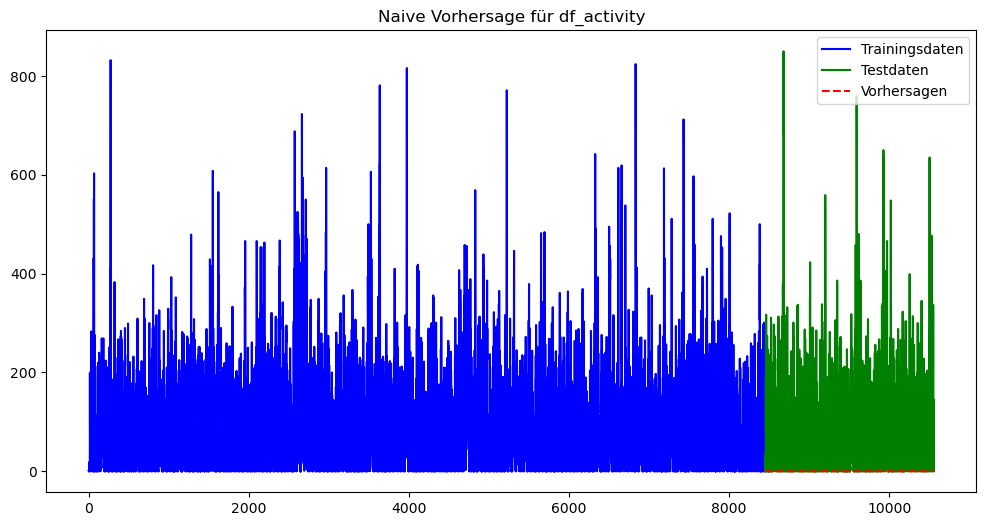

RMSE für Seasonal-Naive Vorhersage (df_activity): 118.3366770227552


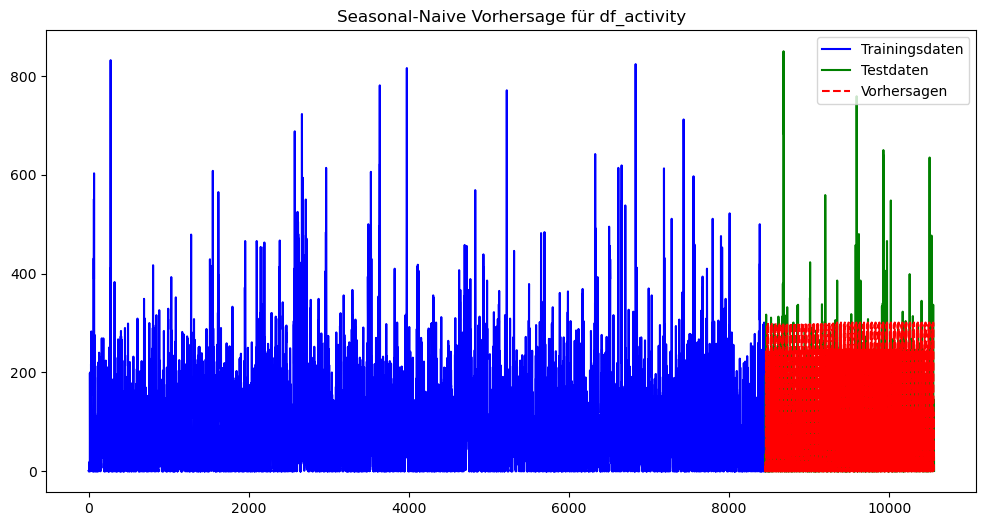

RMSE für Naive Vorhersage (df_t001): 3.19016340003759


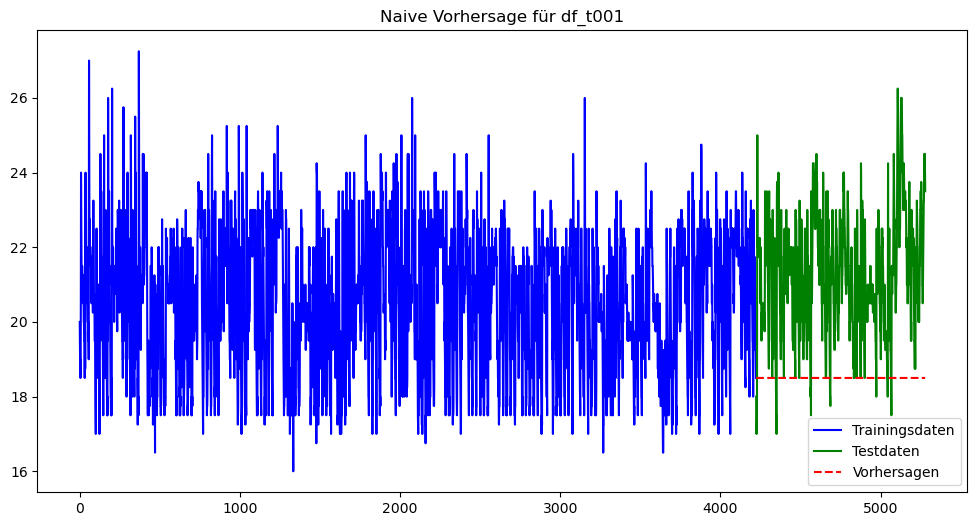

RMSE für Seasonal-Naive Vorhersage (df_t001): 2.248644899172779


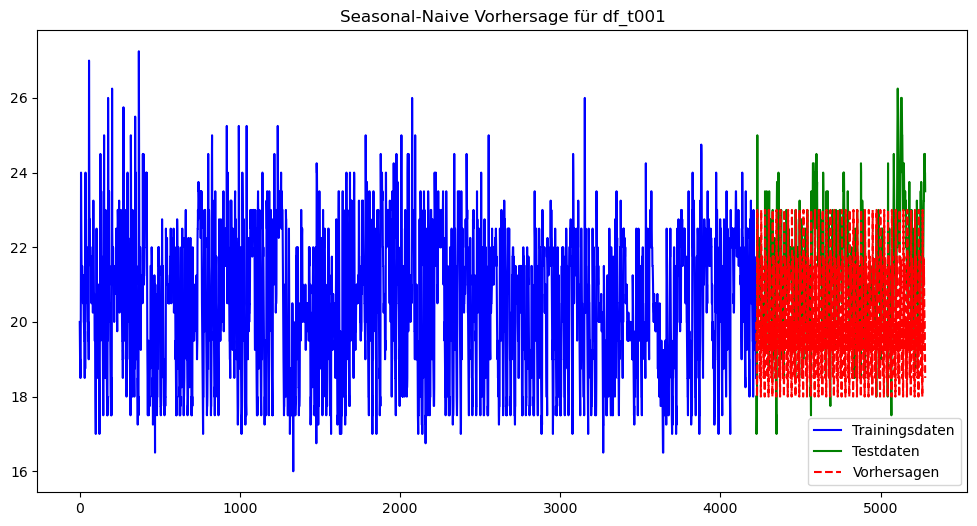

In [34]:
# -- Schritt 1: Datenaufteilung in Trainings- und Testdaten (80%-20%) --
def split_data(df, split_ratio=0.8):
    split_point = int(len(df) * split_ratio)
    train = df.iloc[:split_point]
    test = df.iloc[split_point:]
    return train, test

# Teilen der beiden Datensätze
train_activity, test_activity = split_data(df_activity['Activity'])
train_t001, test_t001 = split_data(df_t001['Value_num'])

print(f"Trainingsdaten df_activity: {len(train_activity)}, Testdaten: {len(test_activity)}")
print(f"Trainingsdaten df_t001: {len(train_t001)}, Testdaten: {len(test_t001)}")

# -- Schritt 2: Naive Vorhersage --
def naive_forecast(train, test):
    """Naive Vorhersage: Der letzte Trainingswert wird für alle Testwerte verwendet."""
    last_value = train.iloc[-1]
    predictions = np.full(len(test), last_value)
    return predictions

# -- Schritt 3: Seasonal Naive Vorhersage --
def seasonal_naive_forecast(train, test, season_length):
    """Seasonal Naive Vorhersage: Nimmt Werte aus der letzten Saison."""
    predictions = []
    for i in range(len(test)):
        predictions.append(train.iloc[-season_length + (i % season_length)])
    return np.array(predictions)

# -- Schritt 4: RMSE berechnen --
def calculate_rmse(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# -- Schritt 5: Visualisierung der Ergebnisse --
def plot_forecasts(train, test, predictions, title):
    plt.figure(figsize=(12, 6))
    plt.plot(train, label="Trainingsdaten", color="blue")
    plt.plot(test.index, test.values, label="Testdaten", color="green")
    plt.plot(test.index, predictions, label="Vorhersagen", color="red", linestyle="--")
    plt.title(title)
    plt.legend()
    plt.show()

# -- Naive Vorhersage für df_activity --
naive_preds_activity = naive_forecast(train_activity, test_activity)
rmse_naive_activity = calculate_rmse(test_activity.values, naive_preds_activity)
print(f"RMSE für Naive Vorhersage (df_activity): {rmse_naive_activity}")

# Visualisierung für Naive Vorhersage
plot_forecasts(train_activity, test_activity, naive_preds_activity, "Naive Vorhersage für df_activity")

# -- Seasonal-Naive Vorhersage für df_activity --
season_length_activity = 48  # 30-Minuten-Daten mit täglicher Saisonalität
seasonal_naive_preds_activity = seasonal_naive_forecast(train_activity, test_activity, season_length_activity)
rmse_seasonal_activity = calculate_rmse(test_activity.values, seasonal_naive_preds_activity)
print(f"RMSE für Seasonal-Naive Vorhersage (df_activity): {rmse_seasonal_activity}")

# Visualisierung für Seasonal-Naive Vorhersage
plot_forecasts(train_activity, test_activity, seasonal_naive_preds_activity, "Seasonal-Naive Vorhersage für df_activity")

# -- Naive Vorhersage für df_t001 --
naive_preds_t001 = naive_forecast(train_t001, test_t001)
rmse_naive_t001 = calculate_rmse(test_t001.values, naive_preds_t001)
print(f"RMSE für Naive Vorhersage (df_t001): {rmse_naive_t001}")

# Visualisierung für Naive Vorhersage
plot_forecasts(train_t001, test_t001, naive_preds_t001, "Naive Vorhersage für df_t001")

# -- Seasonal-Naive Vorhersage für df_t001 --
season_length_t001 = 24  # 1-Stunden-Daten mit täglicher Saisonalität
seasonal_naive_preds_t001 = seasonal_naive_forecast(train_t001, test_t001, season_length_t001)
rmse_seasonal_t001 = calculate_rmse(test_t001.values, seasonal_naive_preds_t001)
print(f"RMSE für Seasonal-Naive Vorhersage (df_t001): {rmse_seasonal_t001}")

# Visualisierung für Seasonal-Naive Vorhersage
plot_forecasts(train_t001, test_t001, seasonal_naive_preds_t001, "Seasonal-Naive Vorhersage für df_t001")

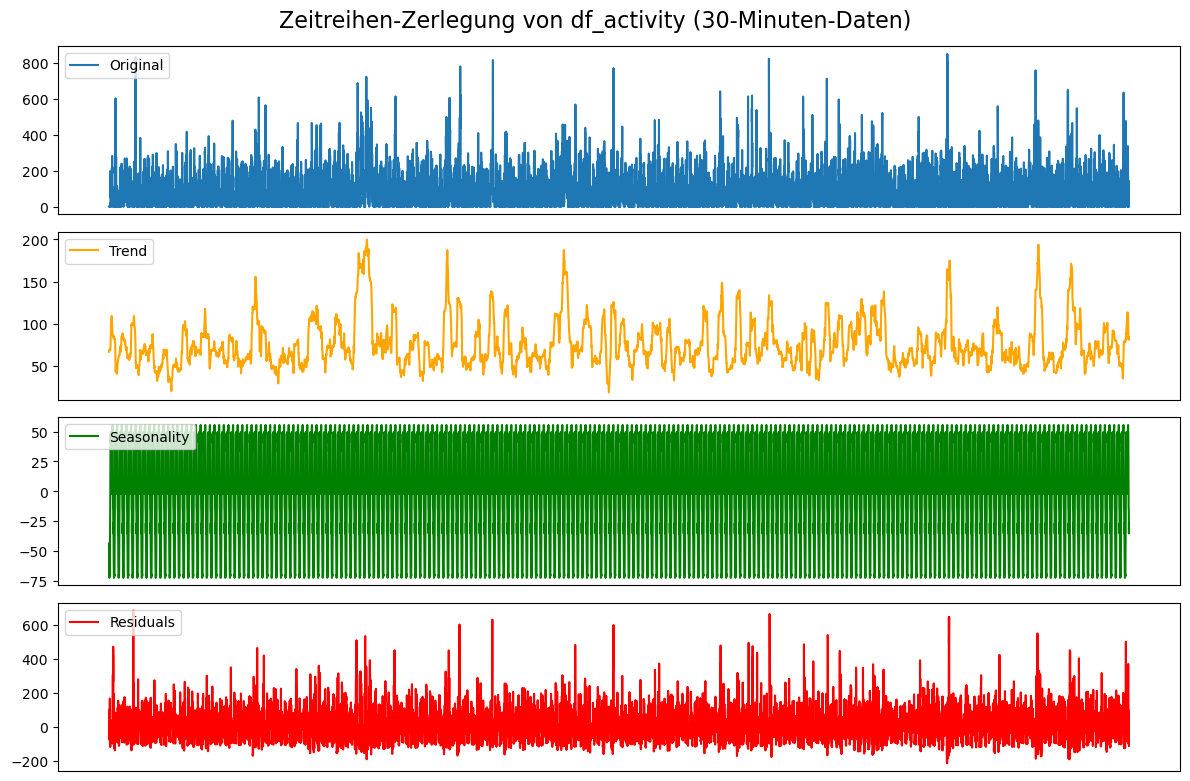

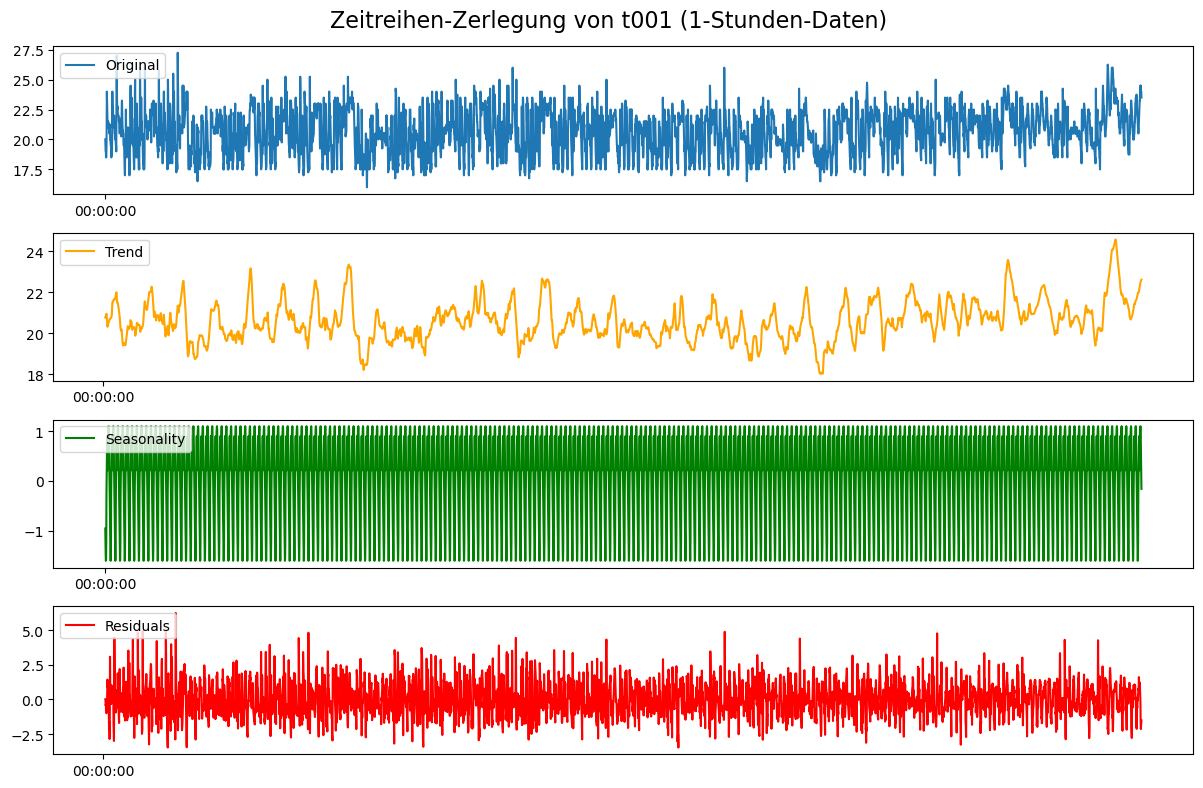

In [38]:
df_activity.index = pd.to_datetime(df_activity.index)
df_t001.index = pd.to_datetime(df_t001.index)

# Für df_activity (30-Minuten-Daten)
result_activity = seasonal_decompose(df_activity['Activity'], model='additive', period=48)
# period=48 für tägliche Saisonalität bei 30-Minuten-Daten (24h / 0.5h = 48)

# Für df_t001 (1-Stunden-Daten)
result_t001 = seasonal_decompose(df_t001['Value_num'], model='additive', period=24)
# period=24 für tägliche Saisonalität bei 1-Stunden-Daten (24h = 24)

# Funktion zur Visualisierung der Komponenten
def plot_decomposition(result, title):
    """Visualisiert die Komponenten einer Zeitreihen-Zerlegung."""
    plt.figure(figsize=(12, 8))
    plt.suptitle(title, fontsize=16)
    
    plt.subplot(411)
    plt.plot(result.observed, label='Original')
    plt.legend(loc='upper left')
    
    plt.subplot(412)
    plt.plot(result.trend, label='Trend', color='orange')
    plt.legend(loc='upper left')
    
    plt.subplot(413)
    plt.plot(result.seasonal, label='Seasonality', color='green')
    plt.legend(loc='upper left')
    
    plt.subplot(414)
    plt.plot(result.resid, label='Residuals', color='red')
    plt.legend(loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Plot für df_activity
plot_decomposition(result_activity, "Zeitreihen-Zerlegung von df_activity (30-Minuten-Daten)")

# Plot für df_t001
plot_decomposition(result_t001, "Zeitreihen-Zerlegung von t001 (1-Stunden-Daten)")